## Conception :

|Auteur|Centre|Modification|
|---|---|---|
|A. RIGAUT|Arras|2021/01/20|
|B. THIBAULT|Arras|2021/01/20|
|R. VANCAMP|Arras|2021/01/20|
|T. POLY|Arras|2021/01/20|
|V. NAESSENS|Arras|2021/01/20|

![image.png](attachment:f4145b12-db17-4854-936b-24036336ecf5.png)





## Contexte

L’entreprise voulant automatiser la sélection de photos pour l’annotations, le livrable 2 devra fournir une méthode de classification se basant sur les réseaux de neurones afin de filtrer les images qui ne sont pas des photos du dataset de départ.

![image.png](attachment:a8aefe04-e295-4227-99a9-d929bab63258.png)

Ce livrable concerne la dernière étape du traitement requis. L’objectif est de créer un réseau de neurones qui génère des légendes pour des photographies, en s’appuyant sur le dataset MS-COCO. Le réseau sera composé de deux parties, la partie CNN qui encode les images en une représentation interne, et la partie RNN qui utilise cette représentation pour prédire l’annotation séquence par séquence. Avant l’entrainement du modèle, les images sont prétraitées par un CNN préentrainé pour la classification. Le prétraitement requis par le réseau est fourni.

Ce livrable démontre notre démarche et explique les choix que nous avons fait afin d'atteindre notre objectif.

In [9]:
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [2]:
annotation_folder = "D:/MachineLearning/annotations/"
annotation_file = "D:/MachineLearning/annotations/captions_train2014.json"

image_folder = 'D:/MachineLearning/train2014/'
PATH = image_folder

print("annotation file ", annotation_file)
print("le chemin PATH ", PATH)

annotation file  D:/MachineLearning/annotations/captions_train2014.json
le chemin PATH  D:/MachineLearning/train2014/


## Limiter la taille de l'ensemble d'entraînement

Pour accélérer notre processus, vous utiliserez un sous-ensemble de 30 000 légendes et leurs images correspondantes pour entraîner notre modèle. Choisir d'utiliser plus de données entraînerait une amélioration de la qualité du sous-titrage cependant nos ressources meterielles sont limitées.

In [3]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Grouper toutes les annotations ayant le meme identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # marquer le debut et la fin de chaque annotation
    caption = f"<start> {val['caption']} <end>"
    # L'identifiant d'une image fait partie de son chemin d'accès
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    image_path_to_caption[image_path].append(caption)

Ici nous selectionnons les 6000 premiers chemins des images contenues dans le dataset melangé pour le dataset d'entrainement. Il nous avons approximativement 5 légendes par identifiant d'image.

In [4]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


Dans cette étape nous ajoutons de façons iterative les chemins des images ainsi que les légendes associées.

In [5]:
# Liste de toutes les annotations
train_captions = []
# Liste de tous les noms de fichiers des images dupliquées (en nombre d'annotations par image)
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

Voici un exemple d'une image avec sa premiere légende. Nous prenons connaissance du dataset ce qui va être important pour la suite.

30013 30013
<start> Black and white photo of woman appearing to be pregnant on bench backed by wall.  <end>


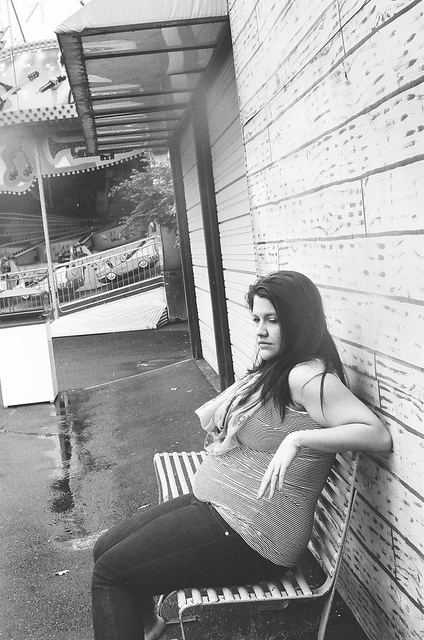

In [6]:
print(len(train_captions), len(img_name_vector))
print(train_captions[0])
Image.open(img_name_vector[0])

# 2 Prétraitement des images

### Inception V3

Nous allons utiliser le modèle pré-entrainé de google permettant de nous assister dans la detection d'object et dans l'analyse d'image. il a été entrainé sur imageNet, qui est une base de données d'objets visuels classifiés qui regroupe des millions d'images et environ 1000 catégories.
Le modèle Inception V3 a été entrainé sur 1 million d'images pour les classifier en 1000 classes. 
quelques exemples 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias','tiger shark, Galeocerdo cuvieri'. 

#### Architecture

Le réseau Inception v3 est un réseau de neurones à convolution. Ainsi, nous pouvons diviser ce réseau en deux. Nous allons avoir une phase dite d'extraction des données et une phase dite de classification. Durant la phase d'extraction, nous allons ajouter des modules Inceptions. Vous avez un schéma de ce réseau ci-dessous qui représente l'ensemble du réseau.

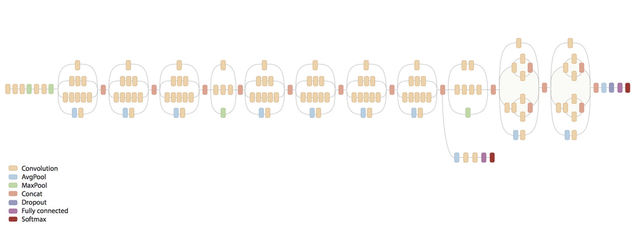

Ce choix est motivé par des raisons de performance. En effet, ce modèle est déjà entraîné sur des millions d'images. Ainsi, la phase dite d'extraction des données est extrêmement performante. En effet, vu qu'elle s'est entraînée sur plusieurs catégories et images différentes, le réseau sait exactement quelle caractéristique extraire afin de classifier au mieux les informations.

#### Initialisez InceptionV3 et chargez les poids Imagenet pré-entraînés

Nous allons maintenant créer un modèle tf.keras où la couche de sortie est la dernière couche convolutionnelle de l'architecture InceptionV3. La forme de la sortie de cette couche est 8x8x2048 .
Nous utilisons la dernière couche convolutive car nous utilisons l'attention. Nous n'effectuons pas cette initialisation pendant l'entraînement car cela pourrait devenir un goulot d'étranglement.
- Nous transférons chaque image à travers le réseau et Nous stockons le vecteur résultant dans un dictionnaire (image_name -> feature_vector).
- Une fois que toutes les images sont passées sur le réseau, nous sélectionnons le dictionnaire et nous l'enregistrons sur le disque.


In [5]:
# Telechargement du modèle InceptionV3 pré-entrainé avec la cassification sur ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
# Creation d'une variable qui sera l'entrée du nouveau modèle de pre-traitement d'images
new_input =  image_model.input
# récupérer la dernière couche caché qui contient l'image en representation compacte
hidden_layer =  image_model.layers[-1].output

# Modèle qui calcule une representation dense des images avec InceptionV3
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

NameError: name 'tf' is not defined

In [8]:
def load_image(image_path):
    """
    La fonction load_image a pour entrée le chemin d'une image et pour sortie un couple
    contenant l'image traitée ainsi que son chemin d'accès.
    La fonction load_image effectue les traitement suivant:
        1. Chargement du fichier correspondant au chemin d'accès image_path
        2. Décodage de l'image en RGB.
        3. Redimensionnement de l'image en taille (299, 299).
        4. Normalisation des pîxels de l'image entre -1 et 1
    """
    img =  tf.io.read_file(image_path)
    img =  tf.image.decode_jpeg(img, channels=3)
    img =  tf.image.resize(img, (299, 299))
    img =  tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

#### Mise en cache des fonctionnalités extraites d'InceptionV3

Nous pré-traiterons chaque image avec InceptionV3 et nous mettrons en cache la sortie sur le disque. La mise en cache de la sortie dans la RAM serait plus rapide mais aussi gourmande en mémoire, nécessitant 8 * 8 * 2048 floats par image. 

In [ ]:
# Prendre les noms des images
encode_train = sorted(set(img_name_vector))

# Creation d'une instance de "tf.data.Dataset" partant des noms des images 
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Division du données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Parcourir le dataset batch par batch pour effectuez le pré-traitement d'InceptionV3
for img, path in tqdm(image_dataset):
    # Pré-traitement du batch (de taille (16,8,8,2048)) courant par InceptionV3 
    batch_features = image_features_extract_model(img)
    # Resize du batch de taille (16,8,8,2048) en taille (16,64,2048)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    # Parcourir le batch courant et stocker le chemin ainsi que le batch avec np.save()
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # (chemin de l'image associe a sa nouvelle representation , representation de l'image)
        np.save(path_of_feature, bf.numpy())

# 3 Prétraitement des annotations

- Tout d'abord, Nous allons tokeniser les légendes (par exemple, en les fractionnant sur des espaces). Cela nous donne un vocabulaire de tous les mots uniques dans les données (par exemple, «surf», «football», etc.).
- Ensuite, nous allons limiter la taille du vocabulaire aux 5 000 premiers mots (pour économiser de la mémoire). Nous remplacerons tous les autres mots par le jeton "UNK" (inconnu).
- Nous créeons ensuite des mappages mot-à-index et index-mot.
- Enfin, nous remplissons toutes les séquences pour qu'elles aient la même longueur que la plus longue.

In [11]:
# Trouver la taille maximale 
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Chosir les 5000 mots les plus frequents du vocabulaire
top_k = 5000
#La classe Tokenizer permet de faire du pre-traitement de texte pour reseau de neurones 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# Construit un vocabulaire en se basant sur la liste train_captions
tokenizer.fit_on_texts(train_captions)

# Créer le token qui sert à remplir les annotations pour egaliser leurs longueur
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Creation des vecteurs(liste de token entiers) à partir des annotations (liste de mots)
train_seqs =  tokenizer.texts_to_sequences(train_captions)

# Remplir chaque vecteur à jusqu'à la longueur maximale des annotations
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calcule la longueur maximale qui est utilisée pour stocker les poids d'attention 
# Elle servira plus tard pour l'affichage lors de l'évaluation
max_length = calc_max_length(train_seqs)

## Diviser les données en entrainement et en test

Dans cette partie nous créons un dictionnaire associant les chemins des images avec les annotations, en effet les chemins des images vont être dupliqués car il y a plusieurs annotations par image.

Il nous faut créer nos jeux d'entrainement et de validation en séparant notre dataset, ici nous choisissont respectivement 80% et 20%. 

On va ensuite créer le jeu d'entrainement et le validation sous forme de listes contenants les mappings donc image prétraitée -> jeton d'annotation (ou mot).

In [12]:
img_to_cap_vector = collections.defaultdict(list)
# Creation d'un dictionnaire associant les chemins des images avec (fichier .npy) aux annotationss
# Les images sont dupliquées car il y a plusieurs annotations par image
print(len(img_name_vector), len(cap_vector))
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

"""
Création des datasets de formation et de validation en utilisant 
un fractionnement 80-20 de manière aléatoire
""" 
# Prendre les clés (noms des fichiers d'images traites), *celles-ci ne seront pas dupliquées*
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)
# Diviser des indices en entrainement et test
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

"""
Les jeux d'entrainement et de tests sont sous forme
de listes contenants les mappings :(image prétraitée ---> jeton d'annotation(mot) )
"""

# Boucle pour construire le jeu d'entrainement
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    # Duplication des images en le nombre d'annotations par image
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

# Boucle pour construire le jeu de test
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    # Duplication des images en le nombre d'annotations par image
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

30013 30013


(24010, 24010, 6003, 6003)

In [13]:
BATCH_SIZE = 64 # taille du batch
BUFFER_SIZE = 1000 # taille du buffer pour melanger les donnes
embedding_dim = 256
units = 512 # Taille de la couche caché dans le RNN
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# La forme du vecteur extrait à partir d'InceptionV3 est (64, 2048)
# Les deux variables suivantes representent la forme de ce vecteur
features_shape = 2048
attention_features_shape = 64

# Fonction qui charge les fichiers numpy des images prétraitées
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

# Creation d'un dataset de "Tensor"s (sert à representer de grands dataset)
# Le dataset est cree a partir de "img_name_train" et "cap_train"
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# L'utilisation de map permet de charger les fichiers numpy (possiblement en parallèle)
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Melanger les donnees et les diviser en batchs
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Modèle

L'architecture du modèle est inspirée de l'article https://arxiv.org/pdf/1512.00567v3.pdf .

- Ici, nous extrayons les caractéristiques de la couche convolutive inférieure d'InceptionV3 en nous donnant un vecteur de forme (8, 8, 2048).
- Nous transformons cela à une forme de (64, 2048).
- Ce vecteur est ensuite passé à travers l'encodeur CNN qui se compose d'une seule couche entièrement connectée.
- Le RNN, ici GRU, s'occupe de l'image pour prédire le mot suivant.

In [14]:
class CNN_Encoder(tf.keras.Model):
    # Comme les images sont déjà prétraités par InceptionV3 est représenté sous forme compacte
    # L'encodeur CNN ne fera que transmettre ces caractéristiques à une couche dense
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # forme après fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x =  self.fc(x)
        x =  tf.nn.relu(x)
        return x

In [15]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) forme == (batch_size, 64, embedding_dim)

        # forme de la couche cachée == (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        # Cela vous donne un score non normalisé pour chaque caractéristique de l'image.
        score = self.V(attention_hidden_layer)

        attention_weights =  tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

In [16]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [17]:
# Création de l'encodeur
encoder = CNN_Encoder(embedding_dim)
# Création du décodeur
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [18]:
# Optimiseur ADAM
optimizer = tf.keras.optimizers.Adam()
# La fonction de perte
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [19]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [20]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # Restaurer le dernier checkpoint dans checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

## Entrainement

- Nous extrayons les fonctionnalités stockées dans les fichiers .npy respectifs, puis nous passons ces fonctionnalités via l'encodeur.
- La sortie du codeur, l'état caché (initialisé à 0) et l'entrée du décodeur (qui est le jeton de démarrage) sont transmis au décodeur.
- Le décodeur renvoie les prédictions et l'état caché du décodeur.
- L'état caché du décodeur est ensuite renvoyé dans le modèle et les prédictions sont utilisées pour calculer la perte.
- Utilisez le forçage de l'enseignant pour décider de la prochaine entrée du décodeur.
- Le forçage par l'enseignant est la technique par laquelle le mot cible est transmis comme entrée suivante au décodeur.
- La dernière étape consiste à calculer les dégradés et à l'appliquer à l'optimiseur et à la rétropropagation.

In [21]:
loss_plot = []
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    # Initialiser l'entrée du décodeur
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: # Offre la possibilité de calculer le gradient du loss
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct à l'étap i est donné en entrée à l'étape (i+1)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # sauvegarde de la perte
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

# Affichage de la courbe d'entrainement
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

## Légende

- La fonction d'évaluation est similaire à la boucle d'apprentissage, sauf que nous n'utilisons pas le forçage de l'enseignant ici. L'entrée du décodeur à chaque pas de temps correspond à ses prédictions précédentes avec l'état caché et la sortie du codeur.
- Nous arretons de prédire quand le modèle prédit le jeton de fin.
- Et nous stockons les poids d'attention pour chaque pas de temps.

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
# Affichage de quelques annotations dans le jeu de test
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Prediction sur nos propres images

Pour finir, nous avons produit une méthode pour sous-titrer nos propres images avec le modèle que nous venons de former. Nous sommes conscients qu'il a été formé sur une quantité relativement petite de données et que nos images peuvent être différentes des données d'entraînement, donc l'apparissions de données un peu étrange est tout à fait normal.

In [ ]:
image = "C:/Users/Arnaud/Desktop/OptionML/projet/data/train/photo/photo_0046.jpg"

In [ ]:
image_path = image

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
#plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)